In [35]:
# !pip install easyocr

In [36]:
import os
import cv2
import copy
import easyocr
import numpy as np
import matplotlib.pyplot as plt

In [37]:
reader = easyocr.Reader(['en'], gpu=True)

In [38]:
def enhance_image_stepwise(image_array, contrast=1.5, brightness=2):

    # Step 1: Denoise the image (optional, can be adjusted or skipped)
    denoised_image = cv2.bilateralFilter(image_array, d=9, sigmaColor=75, sigmaSpace=75)
    
    # Step 2: Increase contrast using histogram equalization
    contrast_enhanced = cv2.convertScaleAbs(image_array, alpha=contrast, beta=brightness)
    
    # Step 3: Strong sharpening with a custom kernel
    strong_sharpen_kernel = np.array([[0, -1, 0],
                                      [-1, 5, -1],
                                      [0, -1, 0]])  # More aggressive sharpening
    sharpened = cv2.filter2D(contrast_enhanced, -1, strong_sharpen_kernel)
    
    # Step 4: Apply adaptive thresholding to make text black and background white
    enhanced_text = cv2.adaptiveThreshold(sharpened, 255, 
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY, 
                                          11, 2)
    
    return enhanced_text

In [39]:
def easyocr_text_detection(orig):

    image = copy.deepcopy(orig)
    
    result = reader.readtext(image)

    rectangles = []
    
    # Draw bounding boxes
    for (bbox, text, prob) in result:
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))
        
        x1, y1 = top_left
        x2, y2 = bottom_right
        x1, x2 = min(x1, x2), max(x1, x2)
        y1, y2 = min(y1, y2), max(y1, y2)
        
        rectangles.append([x1, y1, x2, y2])
        # print([x1, y1, x2, y2])

    
    height_full = int(image.shape[0])  # Height of the image
    width_full = int(image.shape[1])   # Width of the image
    
    for rectangle in rectangles:
        width = rectangle[2]- rectangle[0]
        height = rectangle[3] - rectangle[1]
        
        rectangle[1] = int(rectangle[1] - height*0.18)
        if rectangle[1] < 0:
            rectangle[1] = 0
            
        rectangle[3] = int(rectangle[3] + height*0.18)
        if rectangle[3] > height_full:
            rectangle[3] = height_full
            
        rectangle[0] = int(rectangle[0] - width*0.08)
        if rectangle[0] < 0:
            rectangle[0] = 0
    
        rectangle[2] = int(rectangle[2] + width*0.08)
        if rectangle[2] > width_full:
            rectangle[2] = width_full

    for rectangle in rectangles:
        cv2.rectangle(image, (rectangle[0], rectangle[1]), (rectangle[2], rectangle[3]), (0, 255, 0), 1)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(dpi=150)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Citizenship')
    plt.show()
    
    return rectangles

In [40]:
def plot_regions(rectangles, image):
    num_cols = 4
    num_images = len(rectangles)
    num_rows = (num_images + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
    axes = axes.flatten()
    
    for idx, (x1, y1, x2, y2) in enumerate(rectangles):

        roi = image[y1:y2, x1:x2]
        roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(roi_rgb)
        axes[idx].axis('off')  # Hide axes
        axes[idx].set_title(f'Region {idx + 1}')
    
    for j in range(num_images, num_rows * num_cols):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [41]:
def save_regions(rectangles, image, output_dir='cropped_images'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        # Empty the directory if it already exists
        for file_name in os.listdir(output_dir):
            file_path = os.path.join(output_dir, file_name)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Delete the file
                elif os.path.isdir(file_path):
                    os.rmdir(file_path)  # Delete the subdirectory
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    
    for idx, (x1, y1, x2, y2) in enumerate(rectangles):
        # Crop the region of interest (ROI) from the image
        roi = image[y1:y2, x1:x2]
        
        # Save the cropped image
        output_path = os.path.join(output_dir, f'{idx}.png')
        cv2.imwrite(output_path, roi)

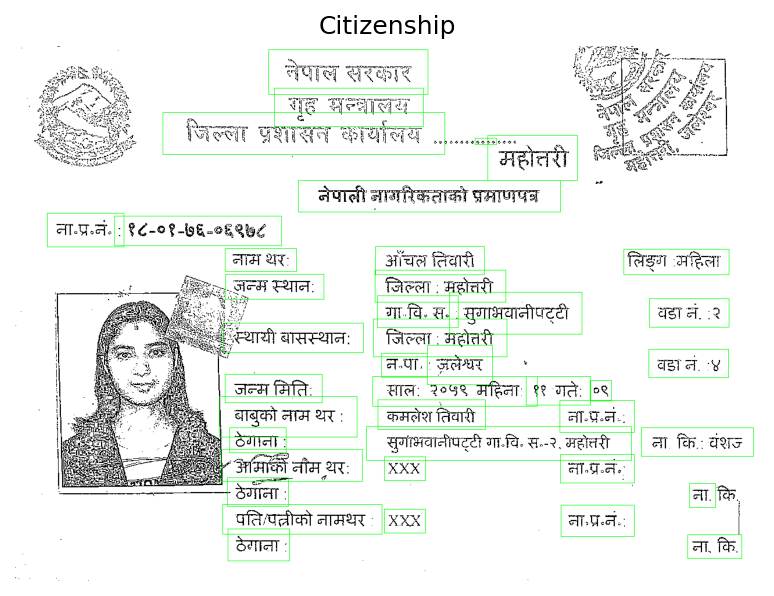

[[436, 6, 710, 83], [446, 72, 702, 138], [254, 114, 739, 186], [791, 158, 828, 169], [813, 153, 967, 231], [487, 231, 938, 285], [55, 287, 187, 345], [171, 292, 458, 343], [361, 348, 484, 387], [620, 344, 807, 393], [1047, 349, 1228, 393], [362, 392, 531, 435], [619, 385, 844, 440], [623, 429, 762, 484], [747, 423, 975, 495], [1091, 434, 1228, 483], [358, 476, 599, 527], [616, 469, 846, 534], [630, 528, 709, 569], [709, 514, 821, 582], [1090, 521, 1227, 570], [361, 564, 528, 613], [615, 568, 898, 619], [879, 568, 990, 617], [989, 575, 1026, 610], [351, 602, 588, 672], [624, 608, 809, 659], [937, 609, 1065, 664], [369, 656, 466, 699], [604, 654, 1060, 712], [1077, 656, 1270, 705], [354, 693, 597, 748], [635, 706, 706, 747], [938, 702, 1065, 751], [365, 742, 470, 791], [1160, 752, 1205, 793], [357, 788, 631, 839], [635, 796, 706, 837], [939, 789, 1065, 843], [366, 830, 472, 885], [1157, 840, 1250, 881]]


In [42]:
# path for any document either in English or Nepali is okay
image = cv2.imread('images/aachal.jpg')
# image = cv2.resize(image, (1000, 700))
# height, width = image.shape[:2]
# print(height, width)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
enhanced_image = enhance_image_stepwise(gray_image, contrast=1.9)
enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB)

rectangles = easyocr_text_detection(enhanced_image_rgb)
print(rectangles)

In [43]:
save_regions(rectangles, image)

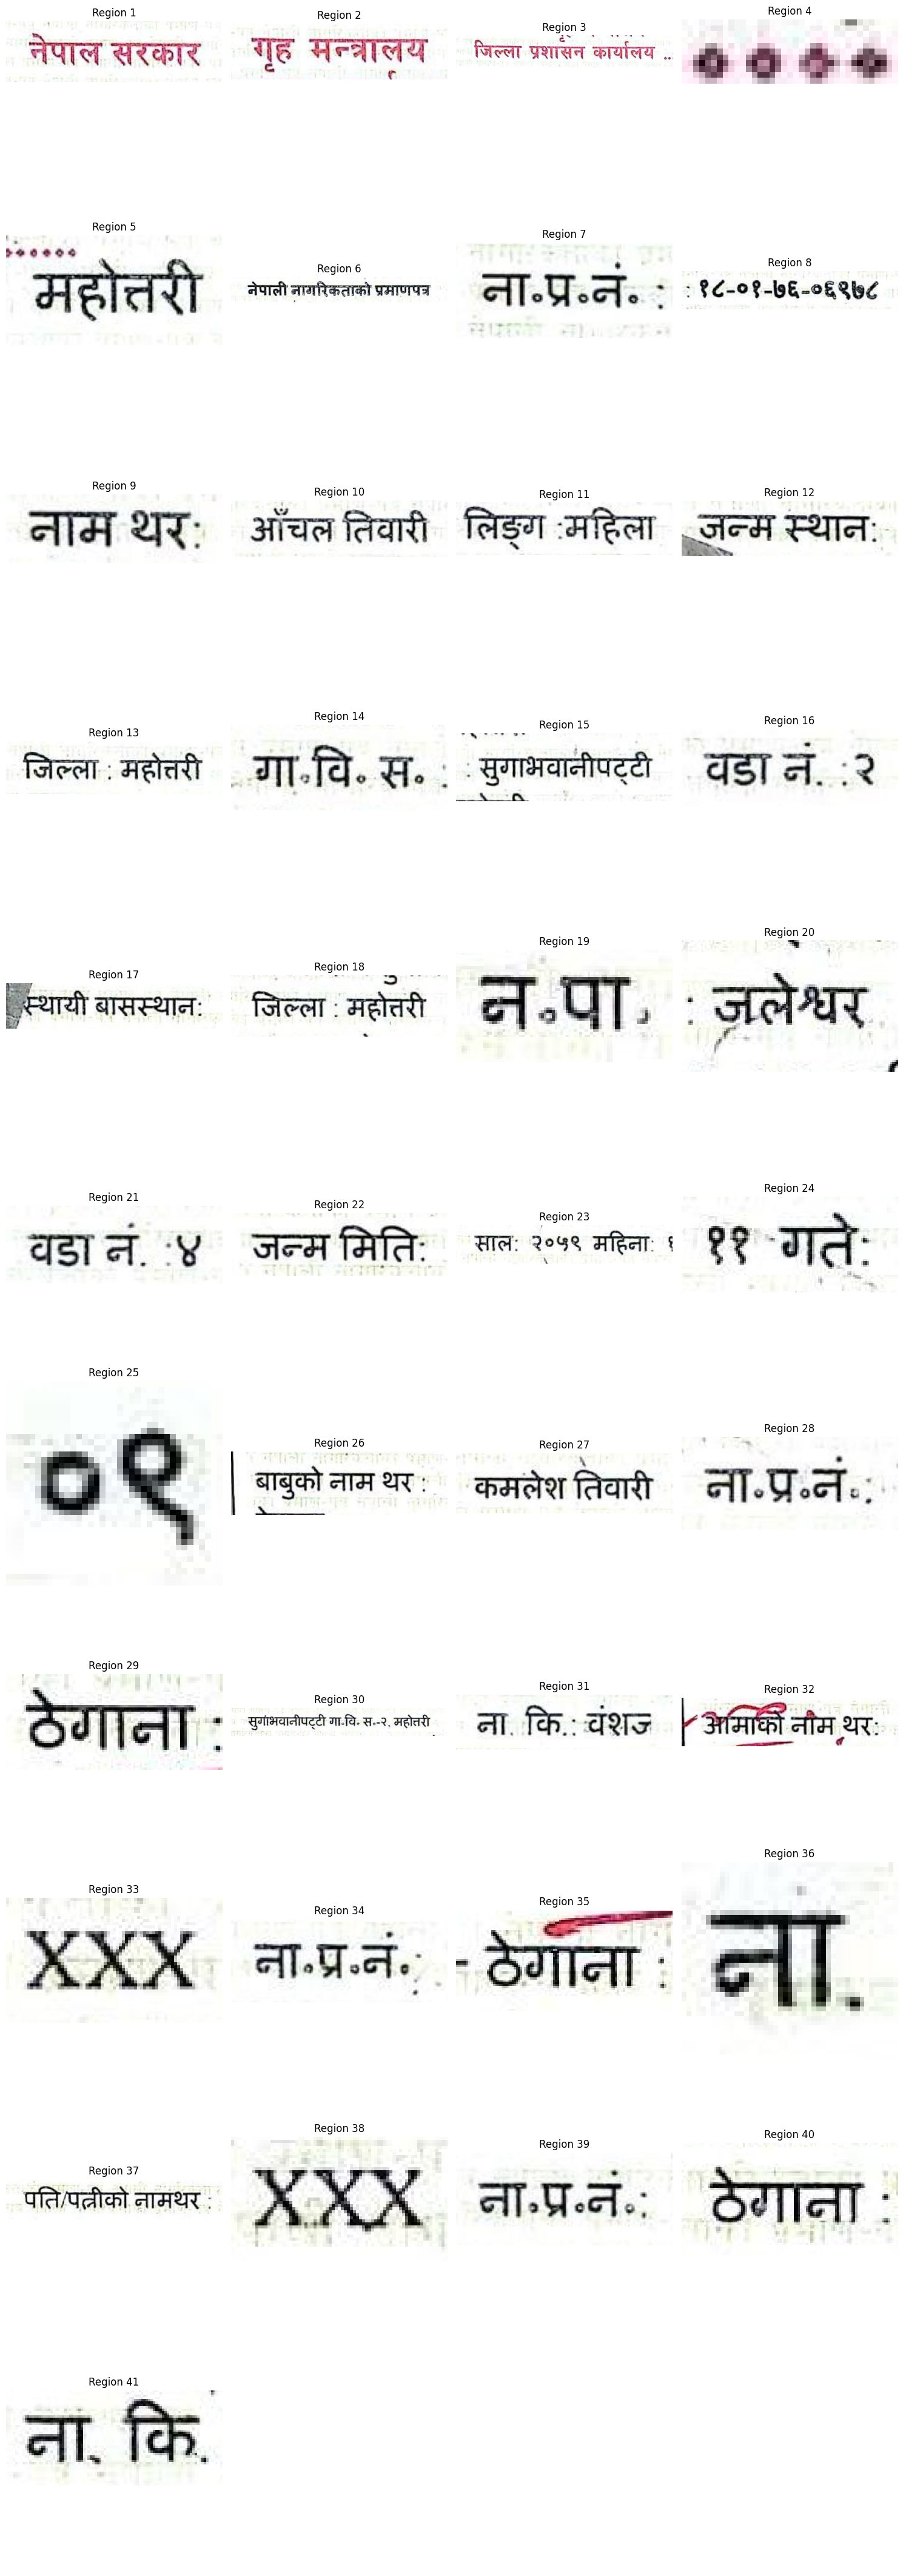

In [44]:
plot_regions(rectangles, image)